This project involves developing a geomagnetic storm forecasting model using OMNI 2 space weather data from the NASA OMNIWEB website. 

The idea is to train a Long Short Term Memory (LSTM) to forecast geomagnetic storm parameters such as the planetary Kp index and the Dst Index.

The necessary data will be downloaded from the website. Link - https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/

Description of the data - https://omniweb.gsfc.nasa.gov/ow.html

In [3]:
# Download the data
import os
import requests
from bs4 import BeautifulSoup

# Define the base URL
base_url = "https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/"

# Create a directory to save the downloaded files
output_dir = "omni_low_res_data"
os.makedirs(output_dir, exist_ok=True)

# File to download
target_file = "omni2_all_years.dat"

# Get the list of files from the directory
response = requests.get(base_url)
if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")
    links = soup.find_all("a", href=True)

    # Check if the target file exists in the directory
    for link in links:
        file_name = link["href"]
        if file_name == target_file:  # Check for the specific file
            file_url = base_url + file_name
            print(f"Downloading {file_name}...")
            file_response = requests.get(file_url)
            if file_response.status_code == 200:
                output_path = os.path.join(output_dir, file_name)
                with open(output_path, "wb") as file:
                    file.write(file_response.content)
                print(f"Saved {file_name} to {output_path}")
            else:
                print(f"Failed to download {file_name}")
            break  # Exit the loop after finding and downloading the file
    else:
        print(f"{target_file} not found in the directory.")
else:
    print("Failed to fetch the directory listing.")

print("Download completed.")


Download completed.


In [1]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

## Read and Clean the Data

In [2]:
# Define file path and column names
# Define the file path
file_path = "omni_low_res_data/omni2_all_years.dat"

# Define column names based on the provided format
column_names = [
    "Year", "Decimal_Day", "Decimal_Hour", "Bartels_Rotation", "IMF_SC_ID",
    "SW_Plasma_SC_ID", "IMF_Points", "Plasma_Points", "Field_Magnitude_Avg",
    "Magnitude_Avg_Field", "Lat_Avg_Field", "Long_Avg_Field", "Bx_GSE",
    "By_GSE", "Bz_GSE", "By_GSM", "Bz_GSM", "Sigma_Field_Mag", "Sigma_B",
    "Sigma_Bx", "Sigma_By", "Sigma_Bz", "Proton_Temperature", "Proton_Density",
    "Bulk_Speed", "Flow_Longitude", "Flow_Latitude", "Alpha_Proton_Ratio",
    "Flow_Pressure", "Sigma_T", "Sigma_N", "Sigma_V", "Sigma_Long",
    "Sigma_Lat", "Sigma_Ratio", "Electric_Field", "Plasma_Beta",
    "Alfven_Mach_Number", "Kp_Index", "Sunspot_Number", "Dst_Index",
    "AE_Index", "Prot_Flux_1MeV", "Prot_Flux_2MeV", "Prot_Flux_4MeV",
    "Prot_Flux_10MeV", "Prot_Flux_30MeV", "Prot_Flux_60MeV", "M_SPH_Flux_Flag",
    "ap_Index", "F10.7_Index", "PC_Index", "AL_Index", "AU_Index",
    "Mach_Number", "Solar_Lyman_Alpha", "Proton_QI"
]

# Define fill values (values that indicate missing data)
fill_values = [999.9, 9999999., 999, 99.99, 99999.99, 99999, 9999, 999.99, 99.9, 999999.99]

try:
    # Load the data into a pandas DataFrame
    data = pd.read_csv(
        file_path,
        delim_whitespace=True,
        names=column_names,
        engine="python"
    )
    print("Data loaded successfully.")
except Exception as e:
    print(f"An error occurred while reading the data: {e}")

Data loaded successfully.


In [3]:
# Replace fill values with NaN
data.replace(fill_values, np.nan, inplace=True)
print("Fill values replaced with NaN.")

Fill values replaced with NaN.


In [4]:
#Convert year, day, and hour into a datetime column
try:
    data["Datetime"] = pd.to_datetime(
        data["Year"].astype(str) + " " + data["Decimal_Day"].astype(str),
        format='%Y %j'
    ) + pd.to_timedelta(data["Decimal_Hour"], unit='h')
    print("Datetime column created successfully.")
except Exception as e:
    print(f"An error occurred while creating the Datetime column: {e}")

Datetime column created successfully.


In [5]:
#  Convert the Kp index values from the OMNI data set scale to the standard scale
data['Kp_Index'] = (data['Kp_Index'] / 10.0).round().astype(int)
data['Kp_Index'] = data['Kp_Index'].clip(upper=9)

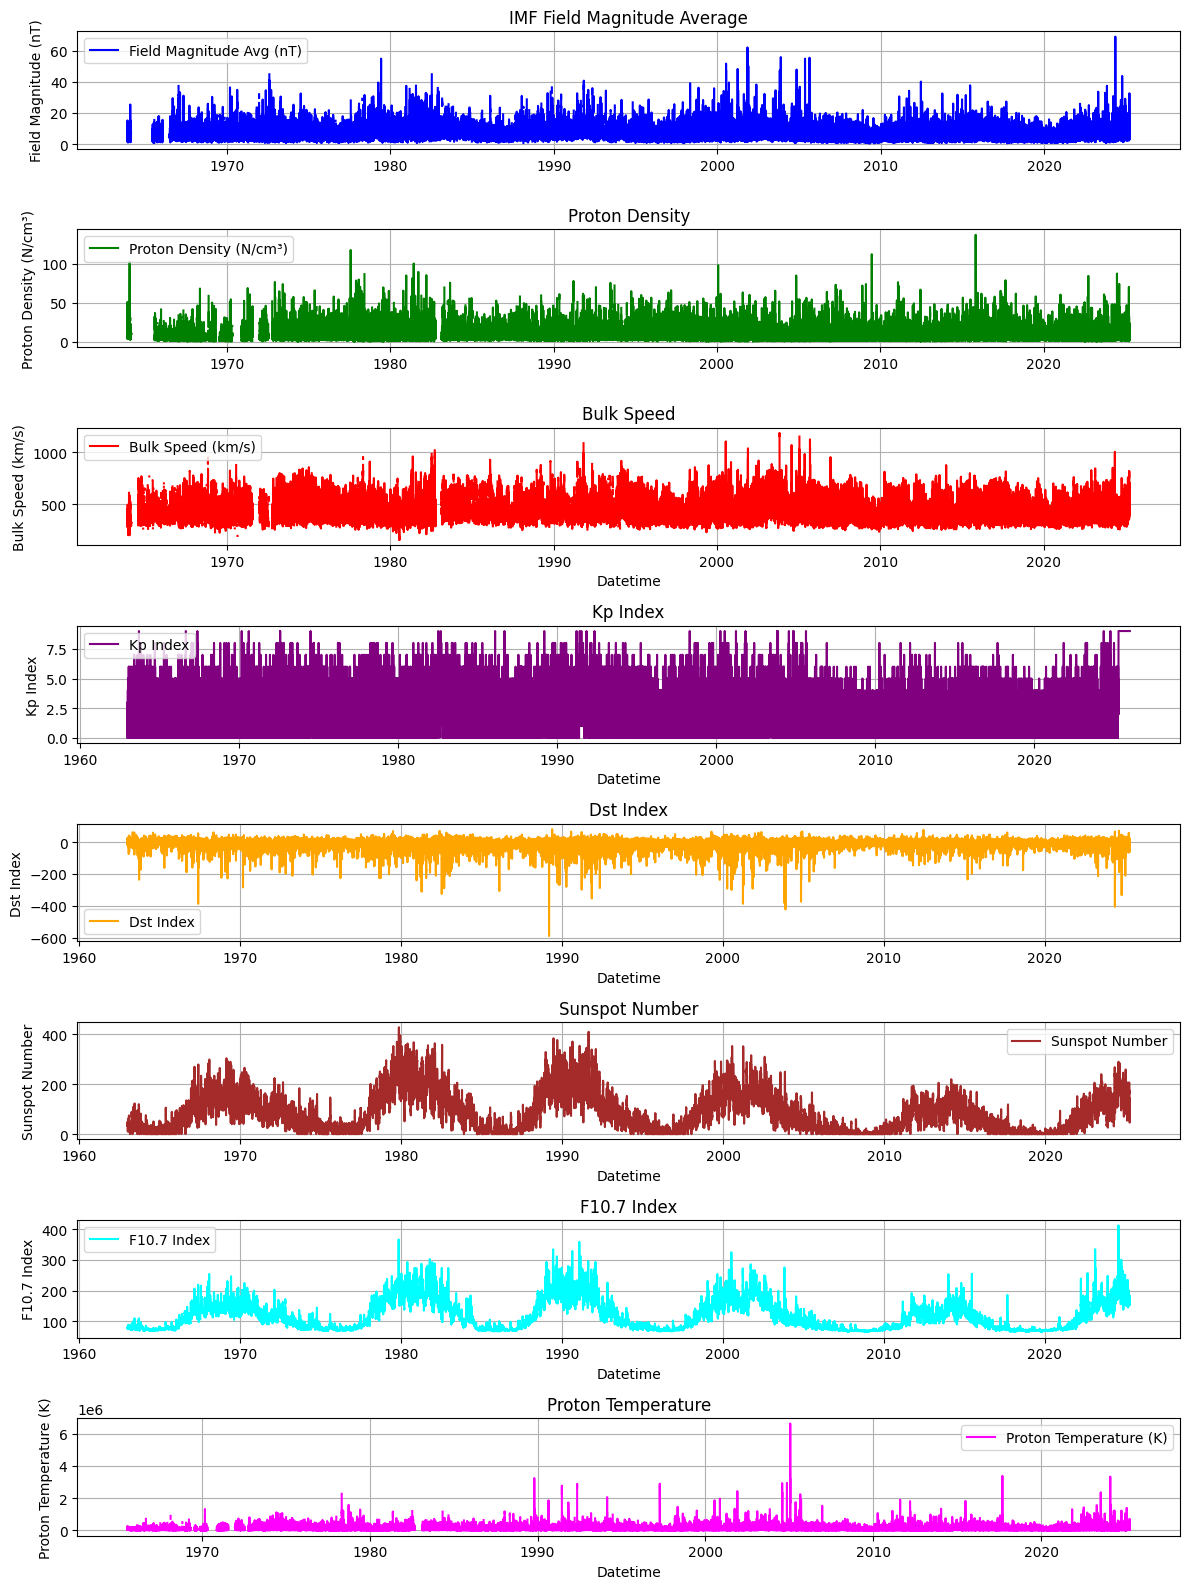

In [6]:
try:
    # Plot some key parameters
    plt.figure(figsize=(12, 16))

    # Plot IMF Field Magnitude Average
    plt.subplot(8, 1, 1)
    plt.plot(data["Datetime"], data["Field_Magnitude_Avg"], label="Field Magnitude Avg (nT)", color="blue")
    plt.ylabel("Field Magnitude (nT)")
    plt.title("IMF Field Magnitude Average")
    plt.grid(True)
    plt.legend()

    # Plot Proton Density
    plt.subplot(8, 1, 2)
    plt.plot(data["Datetime"], data["Proton_Density"], label="Proton Density (N/cm³)", color="green")
    plt.ylabel("Proton Density (N/cm³)")
    plt.title("Proton Density")
    plt.grid(True)
    plt.legend()

    # Plot Bulk Speed
    plt.subplot(8, 1, 3)
    plt.plot(data["Datetime"], data["Bulk_Speed"], label="Bulk Speed (km/s)", color="red")
    plt.xlabel("Datetime")
    plt.ylabel("Bulk Speed (km/s)")
    plt.title("Bulk Speed")
    plt.grid(True)
    plt.legend()

    # Plot Kp Index
    plt.subplot(8, 1, 4)
    plt.plot(data["Datetime"], data["Kp_Index"], label="Kp Index", color="purple")
    plt.xlabel("Datetime")
    plt.ylabel("Kp Index")
    plt.title("Kp Index")
    plt.grid(True)
    plt.legend()

    # Plot Dst Index
    plt.subplot(8, 1, 5)
    plt.plot(data["Datetime"], data["Dst_Index"], label="Dst Index", color="orange")
    plt.xlabel("Datetime")
    plt.ylabel("Dst Index")
    plt.title("Dst Index")
    plt.grid(True)
    plt.legend()

    # Plot Sunspot Number
    plt.subplot(8, 1, 6)
    plt.plot(data["Datetime"], data["Sunspot_Number"], label="Sunspot Number", color="brown")
    plt.xlabel("Datetime")
    plt.ylabel("Sunspot Number")
    plt.title("Sunspot Number")
    plt.grid(True)
    plt.legend()

    # Plot F10.7 Index
    plt.subplot(8, 1, 7)
    plt.plot(data["Datetime"], data["F10.7_Index"], label="F10.7 Index", color="cyan")
    plt.xlabel("Datetime")
    plt.ylabel("F10.7 Index")
    plt.title("F10.7 Index")
    plt.grid(True)
    plt.legend()

    # Plot Proton Temperature
    plt.subplot(8, 1, 8)
    plt.plot(data["Datetime"], data["Proton_Temperature"], label="Proton Temperature (K)", color="magenta")
    plt.xlabel("Datetime")
    plt.ylabel("Proton Temperature (K)")
    plt.title("Proton Temperature")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred while processing the data: {e}")


In [7]:
# List of columns to check for NaN values
columns_to_check = [
    "Bartels_Rotation", "IMF_SC_ID", "SW_Plasma_SC_ID", "IMF_Points", "Plasma_Points", "Field_Magnitude_Avg",
    "Magnitude_Avg_Field", "Lat_Avg_Field", "Long_Avg_Field", "Bx_GSE", "By_GSE", "Bz_GSE", "By_GSM", "Bz_GSM",
    "Sigma_Field_Mag", "Sigma_B", "Sigma_Bx", "Sigma_By", "Sigma_Bz", "Proton_Temperature", "Proton_Density",
    "Bulk_Speed", "Flow_Longitude", "Flow_Latitude", "Alpha_Proton_Ratio", "Flow_Pressure", "Sigma_T", "Sigma_N",
    "Sigma_V", "Sigma_Long", "Sigma_Lat", "Sigma_Ratio", "Electric_Field", "Plasma_Beta", "Alfven_Mach_Number",
    "Kp_Index", "Sunspot_Number", "Dst_Index", "AE_Index", "Prot_Flux_1MeV", "Prot_Flux_2MeV", "Prot_Flux_4MeV",
    "Prot_Flux_10MeV", "Prot_Flux_30MeV", "Prot_Flux_60MeV", "M_SPH_Flux_Flag", "ap_Index", "F10.7_Index", 
    "PC_Index", "AL_Index", "AU_Index", "Mach_Number", "Solar_Lyman_Alpha", "Proton_QI"
]

# Assuming 'data' is your DataFrame
nan_counts = data[columns_to_check].isna().sum()

# Total rows in the DataFrame
total_rows = len(data)

# Calculate the percentage of NaN values for each column
nan_percentage = (nan_counts / total_rows) * 100

# Create a DataFrame to display the NaN counts and percentages neatly
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Total Count':total_rows,
    'Percentage (%)': nan_percentage
})

# Display the table
print(nan_summary)

                     NaN Count  Total Count  Percentage (%)
Bartels_Rotation          6264       552264            1.13
IMF_SC_ID                    0       552264            0.00
SW_Plasma_SC_ID              0       552264            0.00
IMF_Points              153579       552264           27.81
Plasma_Points           149188       552264           27.01
Field_Magnitude_Avg     131642       552264           23.84
Magnitude_Avg_Field     131642       552264           23.84
Lat_Avg_Field           131642       552264           23.84
Long_Avg_Field          131737       552264           23.85
Bx_GSE                  131642       552264           23.84
By_GSE                  131642       552264           23.84
Bz_GSE                  131642       552264           23.84
By_GSM                  131668       552264           23.84
Bz_GSM                  131668       552264           23.84
Sigma_Field_Mag         148660       552264           26.92
Sigma_B                 131798       552

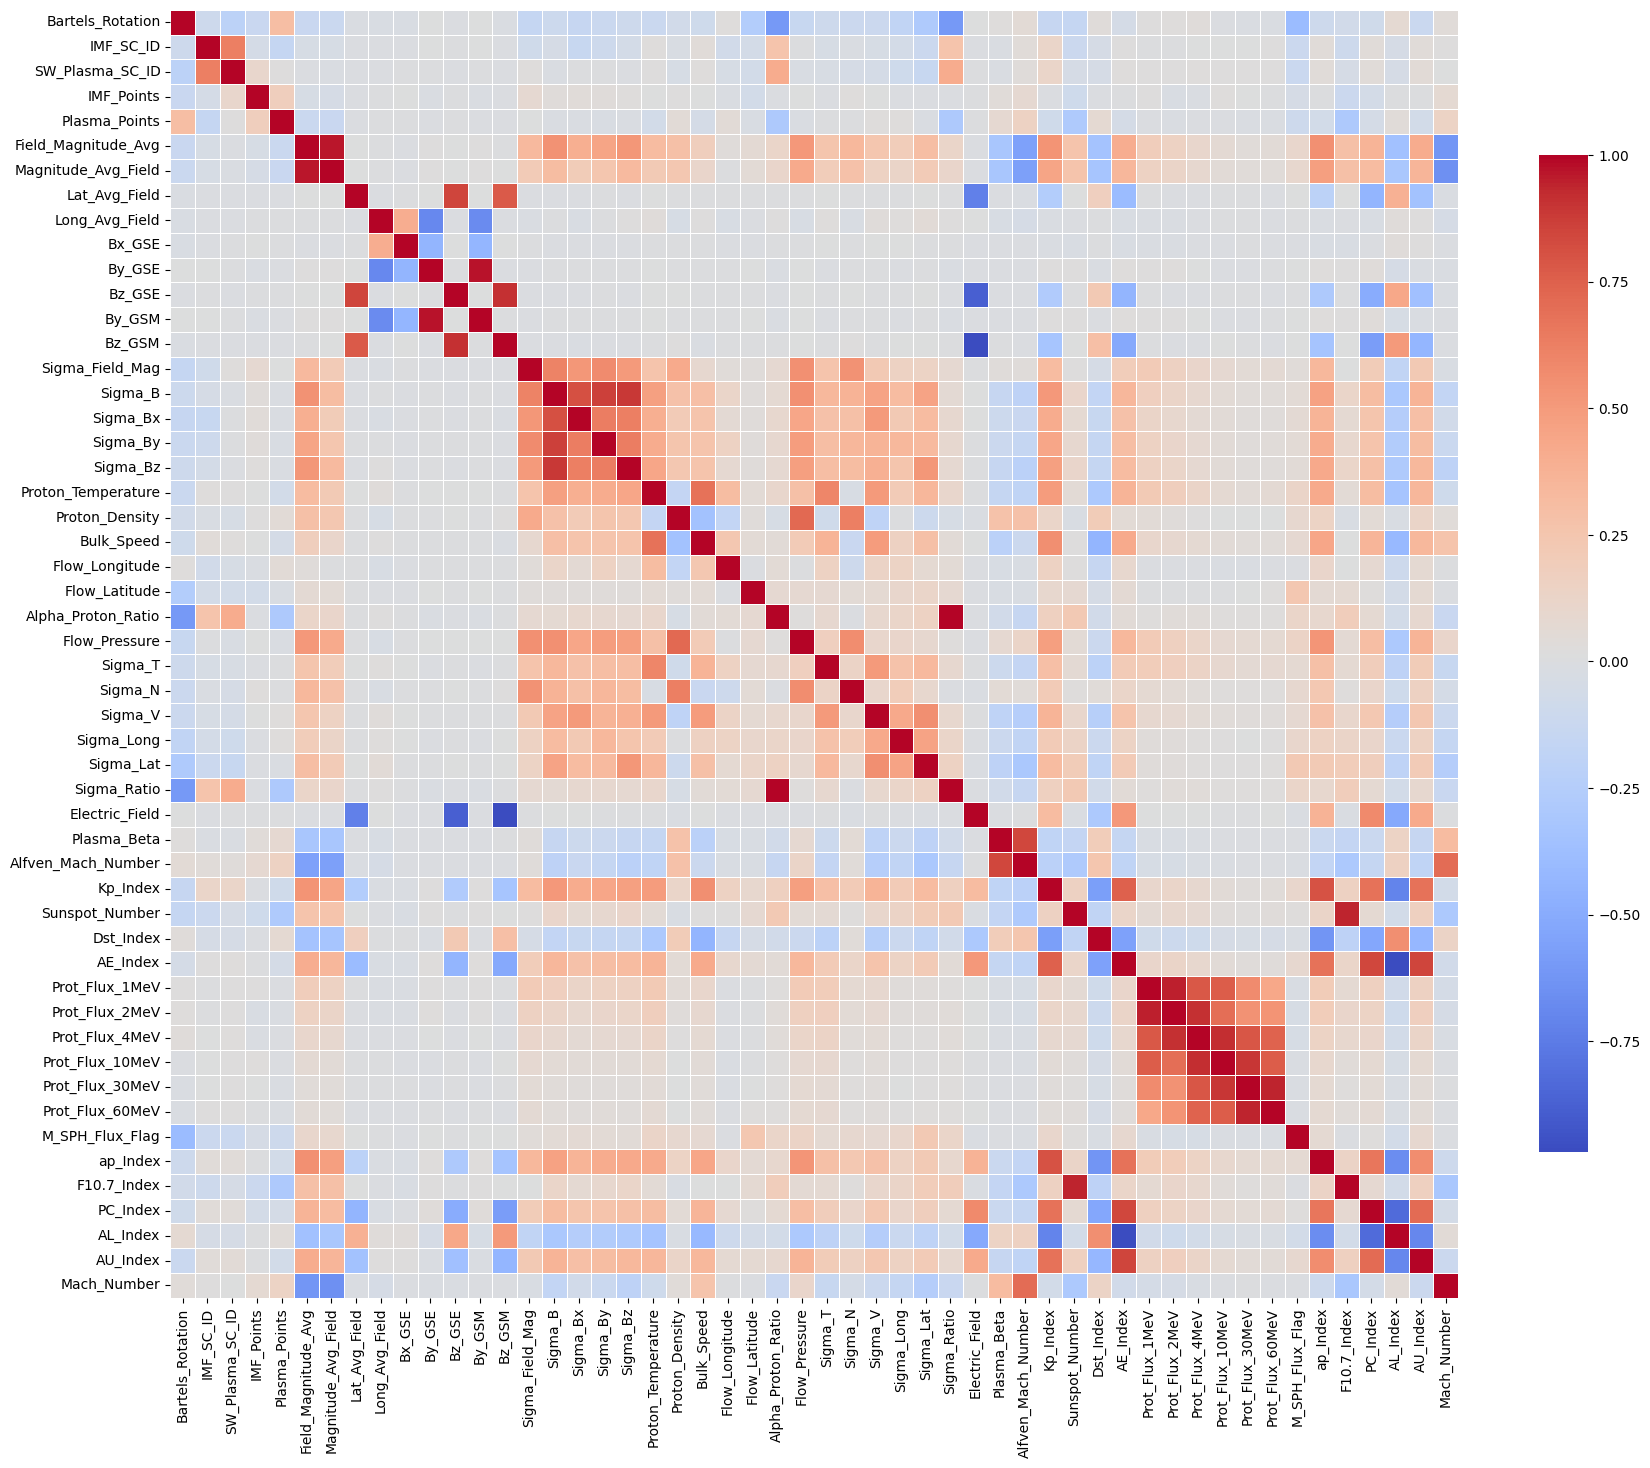

In [8]:

try:
    # Columns to exclude
    exclude_columns = ["Year", "Decimal_Day", "Decimal_Hour"]

    # Select only numeric columns and drop excluded ones
    numeric_data = data.select_dtypes(include=["number"]).drop(columns=exclude_columns, errors='ignore')

    # Drop any columns that are completely NaN
    numeric_data = numeric_data.dropna(axis=1, how='all')

    # Compute correlation matrix
    corr_matrix = numeric_data.corr()

    # Set up the figure
    plt.figure(figsize=(18, 15))

    # Plot heatmap without numbers inside the squares
    sns.heatmap(
        corr_matrix,
        annot=False,   
        cmap="coolwarm",    
        linewidths=0.5,     
        square=True,
        cbar_kws={"shrink": 0.75},  # Show colorbar
        xticklabels=True,
        yticklabels=True
    )

    # Rotate labels and remove extra whitespace
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred while generating the heatmap: {e}")


In [9]:
# Step 1: Calculate the correlation matrix
corr_matrix = data.corr()

# Step 2: Filter columns based on correlation with Kp and Dst
columns_to_keep = []
for col in corr_matrix.columns:
    # If correlation with Kp or Dst is greater than or equal to 0.25
    if abs(corr_matrix[col]['Kp_Index']) >= 0.25 or abs(corr_matrix[col]['Dst_Index']) >= 0.25:
        columns_to_keep.append(col)

# Step 3: Keep only the relevant columns
filtered_data = data[columns_to_keep]

# Optionally: To also drop rows with NaN values in the relevant columns
#filtered_data = filtered_data.dropna()

# Display the filtered dataset
filtered_data.head()

,Field_Magnitude_Avg,Magnitude_Avg_Field,Lat_Avg_Field,Bz_GSE,Bz_GSM,Sigma_Field_Mag,Sigma_B,Sigma_Bx,Sigma_By,Sigma_Bz,Proton_Temperature,Bulk_Speed,Flow_Pressure,Sigma_T,Sigma_V,Sigma_Lat,Electric_Field,Kp_Index,Dst_Index,AE_Index,ap_Index,PC_Index,AL_Index,AU_Index
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-6.00,119.00,3.00,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-5.00,143.00,3.00,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-5.00,66.00,3.00,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,-3.00,51.00,7.00,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,-3.00,95.00,7.00,NaN,NaN,NaN


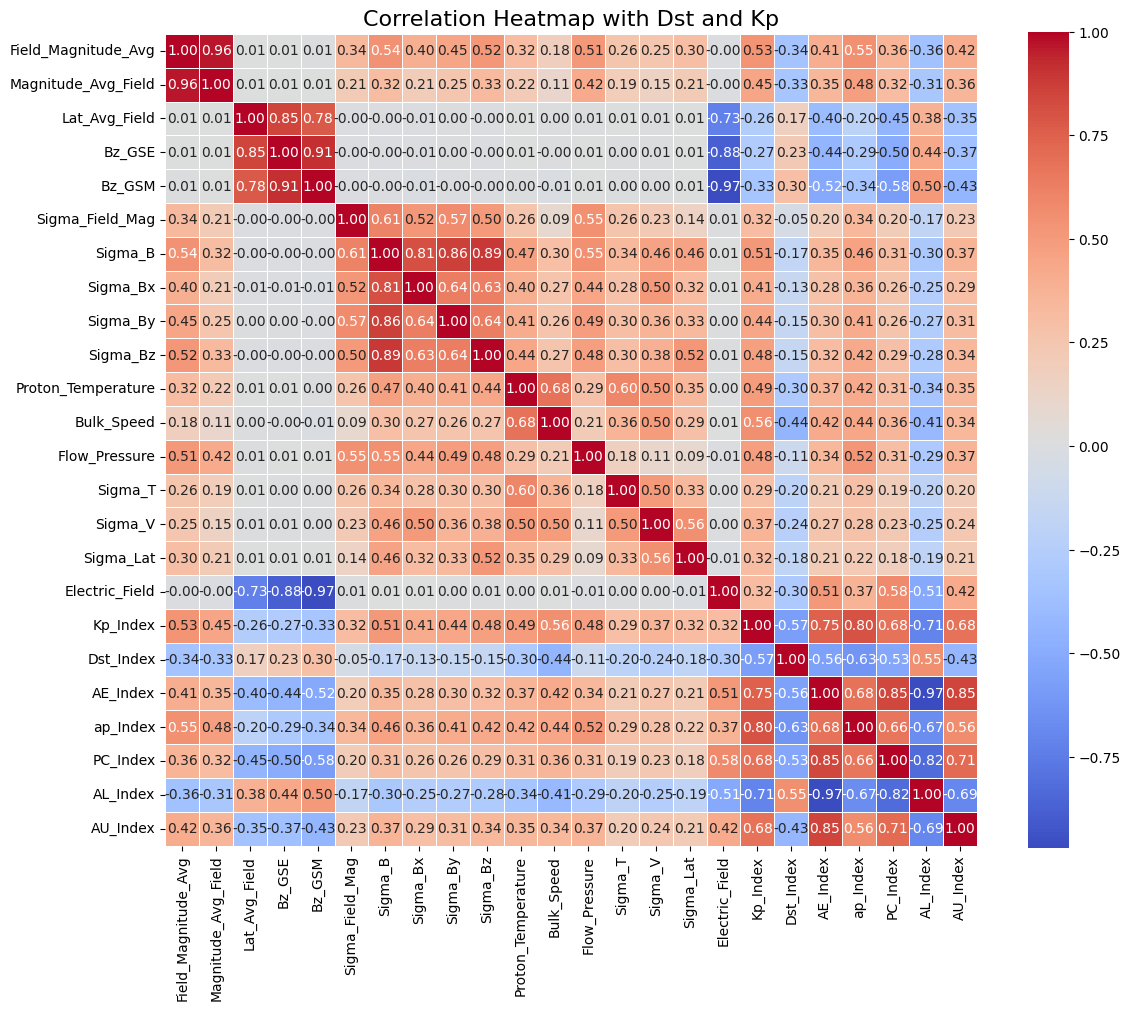

In [10]:
# Select relevant columns, including Dst and Kp
columns_of_interest = filtered_data.columns.tolist()

# Ensure you have the columns you want
filtered_data = filtered_data[columns_of_interest]

# Compute the correlation matrix for the selected columns
corr_matrix = filtered_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with correlation values annotated
sns.heatmap(corr_matrix,
            annot=True,            # Display the correlation values in the cells
            fmt=".2f",             # Format the numbers to 2 decimal places
            cmap="coolwarm",       # Color scheme
            linewidths=0.5,        # Lines between cells
            square=True,           # Ensure the cells are square
            #cbar_kws={"shrink": 0.75},  # Adjust color bar size
            annot_kws={"size": 10})  # Text size for the correlation values

plt.title("Correlation Heatmap with Dst and Kp", fontsize=16)
plt.tight_layout()
#plt.savefig('Heatmap')
plt.show()

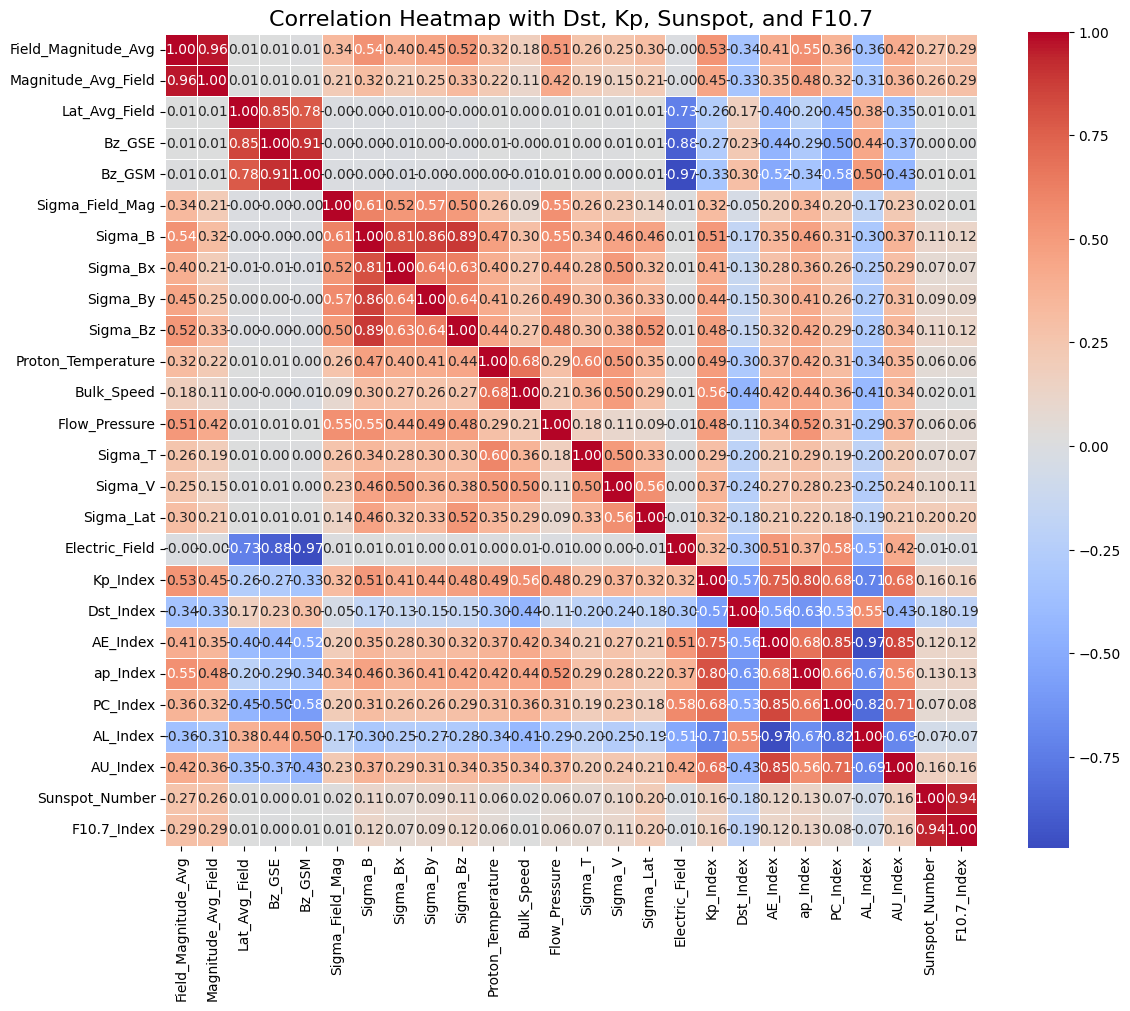

In [11]:

# Extract the two columns from numeric_data
sunspot_and_f107 = numeric_data[['Sunspot_Number', 'F10.7_Index']]

# Ensure that 'Sunspot_Number' and 'F10.7_Index' exist in filtered_data
columns_of_interest = filtered_data.columns.tolist() + ['Sunspot_Number', 'F10.7_Index']

# Merge the extracted columns with filtered_data (only if they exist)
if 'Sunspot_Number' in numeric_data.columns and 'F10.7_Index' in numeric_data.columns:
    filtered_data = filtered_data.join(sunspot_and_f107)
else:
    print("Error: 'Sunspot_Number' and/or 'F10.7_Index' columns not found in numeric_data.")

# Compute the correlation matrix for the selected columns
corr_matrix = filtered_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with correlation values annotated
sns.heatmap(corr_matrix,
            annot=True,            # Display the correlation values in the cells
            fmt=".2f",             # Format the numbers to 2 decimal places
            cmap="coolwarm",       # Color scheme
            linewidths=0.5,        # Lines between cells
            square=True,           # Ensure the cells are square
            annot_kws={"size": 10})  # Text size for the correlation values

plt.title("Correlation Heatmap with Dst, Kp, Sunspot, and F10.7", fontsize=16)
plt.tight_layout()

# Display the heatmap
plt.show()


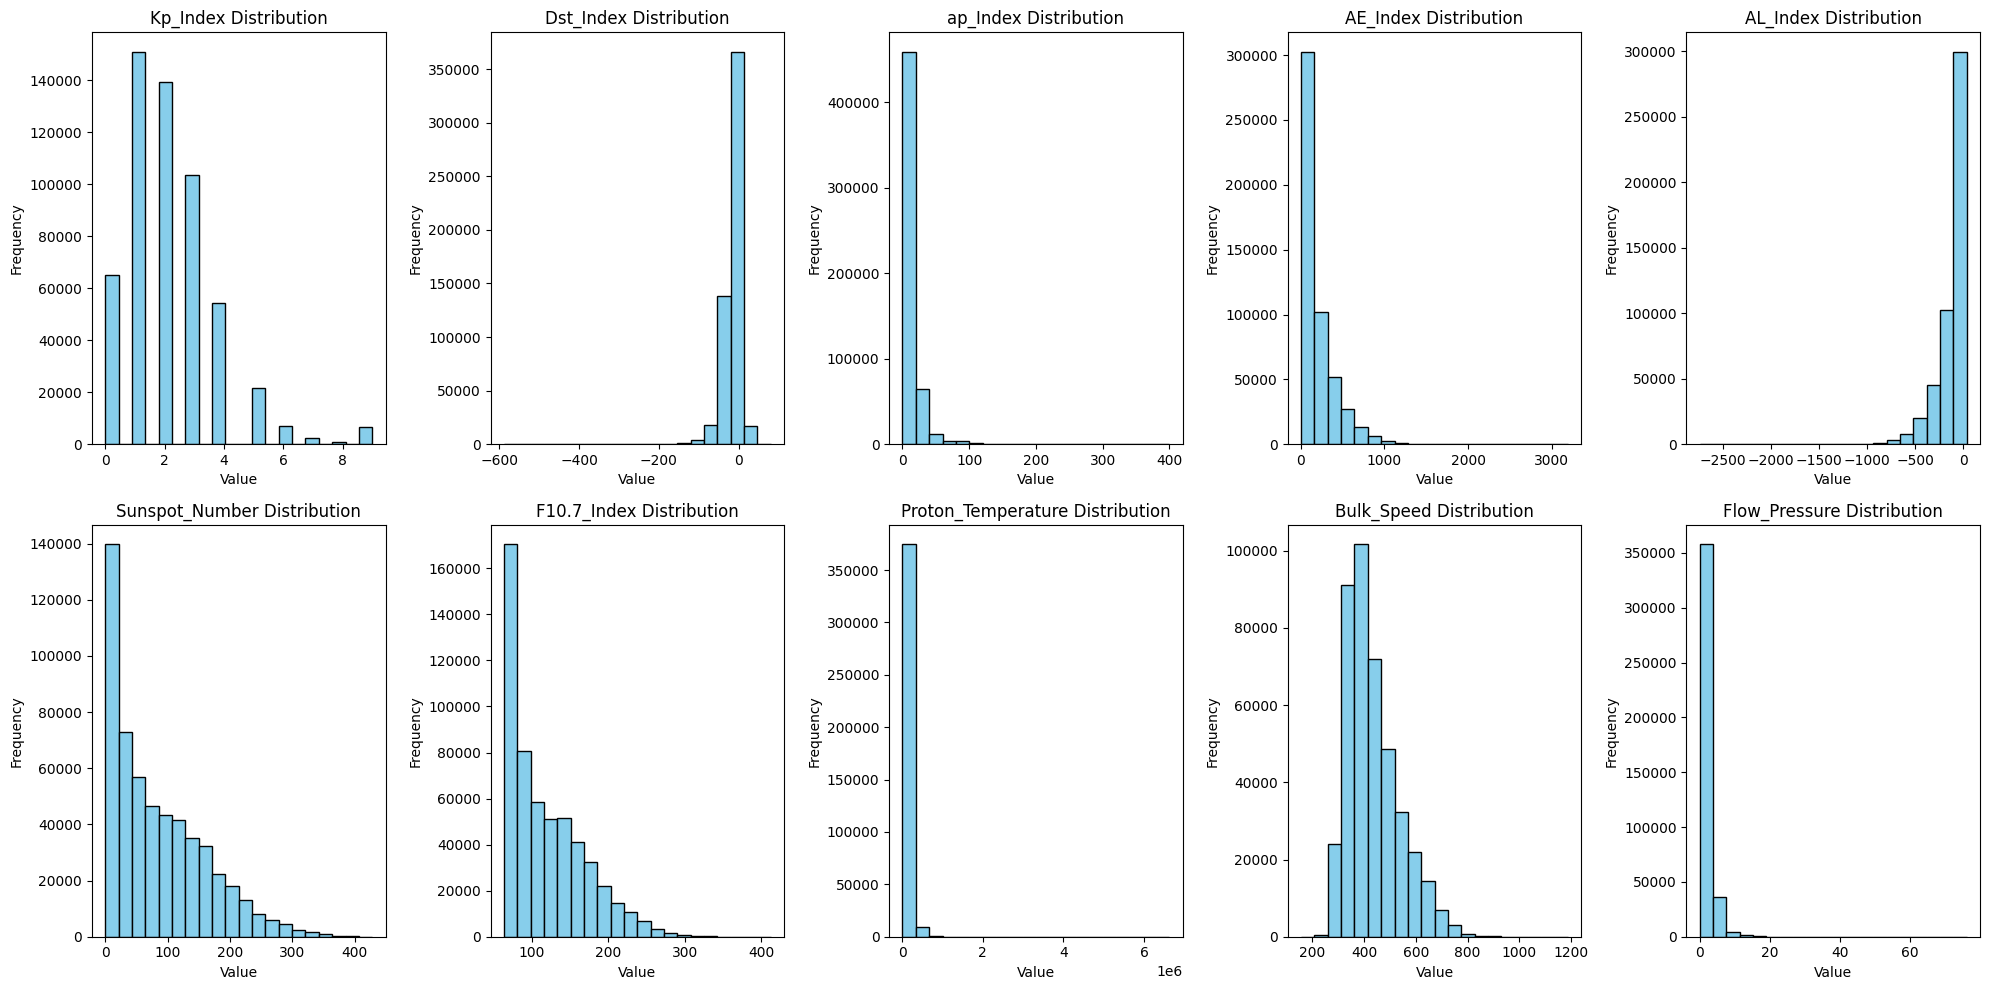

In [12]:
# Define the number of rows and columns for the grid
num_rows = 2
num_cols = 5

# Create a new figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Define the list of columns you want to plot
columns = ['Kp_Index', 'Dst_Index', 'ap_Index', 'AE_Index', 'AL_Index',
           'Sunspot_Number', 'F10.7_Index', 'Proton_Temperature',
           'Bulk_Speed', 'Flow_Pressure']

# Plot histograms for each column from the `filtered_data` DataFrame
for i, col in enumerate(columns):
    if col in filtered_data.columns:
        axes[i].hist(filtered_data[col].dropna(), bins=20, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
    else:
        axes[i].set_visible(False)  # Hide axes if column is missing

# Hide any unused subplots
for j in range(len(columns), len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
# Step 1: Create the Datetime column
try:
    data["Datetime"] = pd.to_datetime(
        data["Year"].astype(str) + " " + data["Decimal_Day"].astype(str),
        format='%Y %j'
    ) + pd.to_timedelta(data["Decimal_Hour"], unit='h')
    print("Datetime column created successfully.")
except Exception as e:
    print(f"An error occurred while creating the Datetime column: {e}")

# Step 2: Copy filtered data (assuming you've already filtered it)
# Example: filtered_data = data[some_condition]  <-- adjust as needed

# Step 3: Insert Datetime as the first column
if 'Datetime' in data.columns:
    filtered_data.insert(0, 'Datetime', data.loc[filtered_data.index, 'Datetime'])
    print("Datetime inserted as the first column.")
else:
    print("Datetime column not found.")


Datetime column created successfully.
Datetime inserted as the first column.


In [14]:
# Step 1: Drop columns that are all NaN
filtered_data_clean = filtered_data.dropna(axis=1, how='all')

# Step 2: Define your desired column order
priority_columns = ['Datetime', 'Kp_Index', 'Dst_Index', 'AE_Index', 'ap_Index', 'Sunspot_Number', 'F10.7_Index']

# Step 3: Get all existing columns in the DataFrame
existing_columns = [col for col in filtered_data_clean.columns if col in priority_columns]

# Step 4: Add the rest of the columns that are not in priority_columns
remaining_columns = [col for col in filtered_data_clean.columns if col not in priority_columns]

# Step 5: Reorder and display
ordered_columns = existing_columns + remaining_columns
filtered_data_clean[ordered_columns].head()


,Datetime,Kp_Index,Dst_Index,AE_Index,ap_Index,Sunspot_Number,F10.7_Index,Field_Magnitude_Avg,Magnitude_Avg_Field,Lat_Avg_Field,Bz_GSE,Bz_GSM,Sigma_Field_Mag,Sigma_B,Sigma_Bx,Sigma_By,Sigma_Bz,Proton_Temperature,Bulk_Speed,Flow_Pressure,Sigma_T,Sigma_V,Sigma_Lat,Electric_Field,PC_Index,AL_Index,AU_Index
0,1963-01-01 00:00:00,1,-6.00,119.00,3.00,33.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1963-01-01 01:00:00,1,-5.00,143.00,3.00,33.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1963-01-01 02:00:00,1,-5.00,66.00,3.00,33.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1963-01-01 03:00:00,2,-3.00,51.00,7.00,33.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1963-01-01 04:00:00,2,-3.00,95.00,7.00,33.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#Calculate NaN count for specified columns
nan_counts = filtered_data_clean.isna().sum()

# Total number of rows in the dataset
total_rows = len(filtered_data_clean)

#  Calculate percentage of NaNs per column
nan_percentage = (nan_counts / total_rows) * 100

#  Create a summary DataFrame
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Total Count': total_rows,
    'Percentage (%)': nan_percentage.round(2)  # Round to 2 decimal places
})

#  Display the summary
print(nan_summary)

                     NaN Count  Total Count  Percentage (%)
Datetime                     0       552264            0.00
Field_Magnitude_Avg     131642       552264           23.84
Magnitude_Avg_Field     131642       552264           23.84
Lat_Avg_Field           131642       552264           23.84
Bz_GSE                  131642       552264           23.84
Bz_GSM                  131668       552264           23.84
Sigma_Field_Mag         148660       552264           26.92
Sigma_B                 131798       552264           23.87
Sigma_Bx                132197       552264           23.94
Sigma_By                132184       552264           23.93
Sigma_Bz                132181       552264           23.93
Proton_Temperature      167698       552264           30.37
Bulk_Speed              134480       552264           24.35
Flow_Pressure           151263       552264           27.39
Sigma_T                 171504       552264           31.05
Sigma_V                 166407       552